<a href="https://colab.research.google.com/github/VindhyaSRajan/Master-s-Thesis/blob/master/Amazon_LDA_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pyLDAvis

In [2]:
import pickle
import gensim
import pyLDAvis
import pyLDAvis.gensim
import spacy
import pandas as pd
import nltk; nltk.download('stopwords')
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import re
import warnings
from pprint import pprint
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/_pytest/mark/structures.py:426: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  @attr.s(cmp=False, hash=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
with open('./rev_train.pkl', 'rb') as f:
    rev_train = pickle.load(f)
with open('./rev_test.pkl', 'rb') as f:
    rev_test = pickle.load(f)

In [6]:
rev_train = pd.read_csv('/content/drive/My Drive/Amazon_data/reviews_Patio_Lawn_And_Garden.csv',nrows=100000)
rev_train.head()
rev_train.shapec#Shape should be (100000,9)

(100000, 9)

In [7]:
rev_train = rev_train[rev_train['reviewText'].notnull()]
rev_train['text_len'] = rev_train['reviewText'].apply(lambda x: len(x.split()))
rev_train.head()
rev_train.shape #Empty records taken off. Shape comes to (99941,10)

(99941, 10)

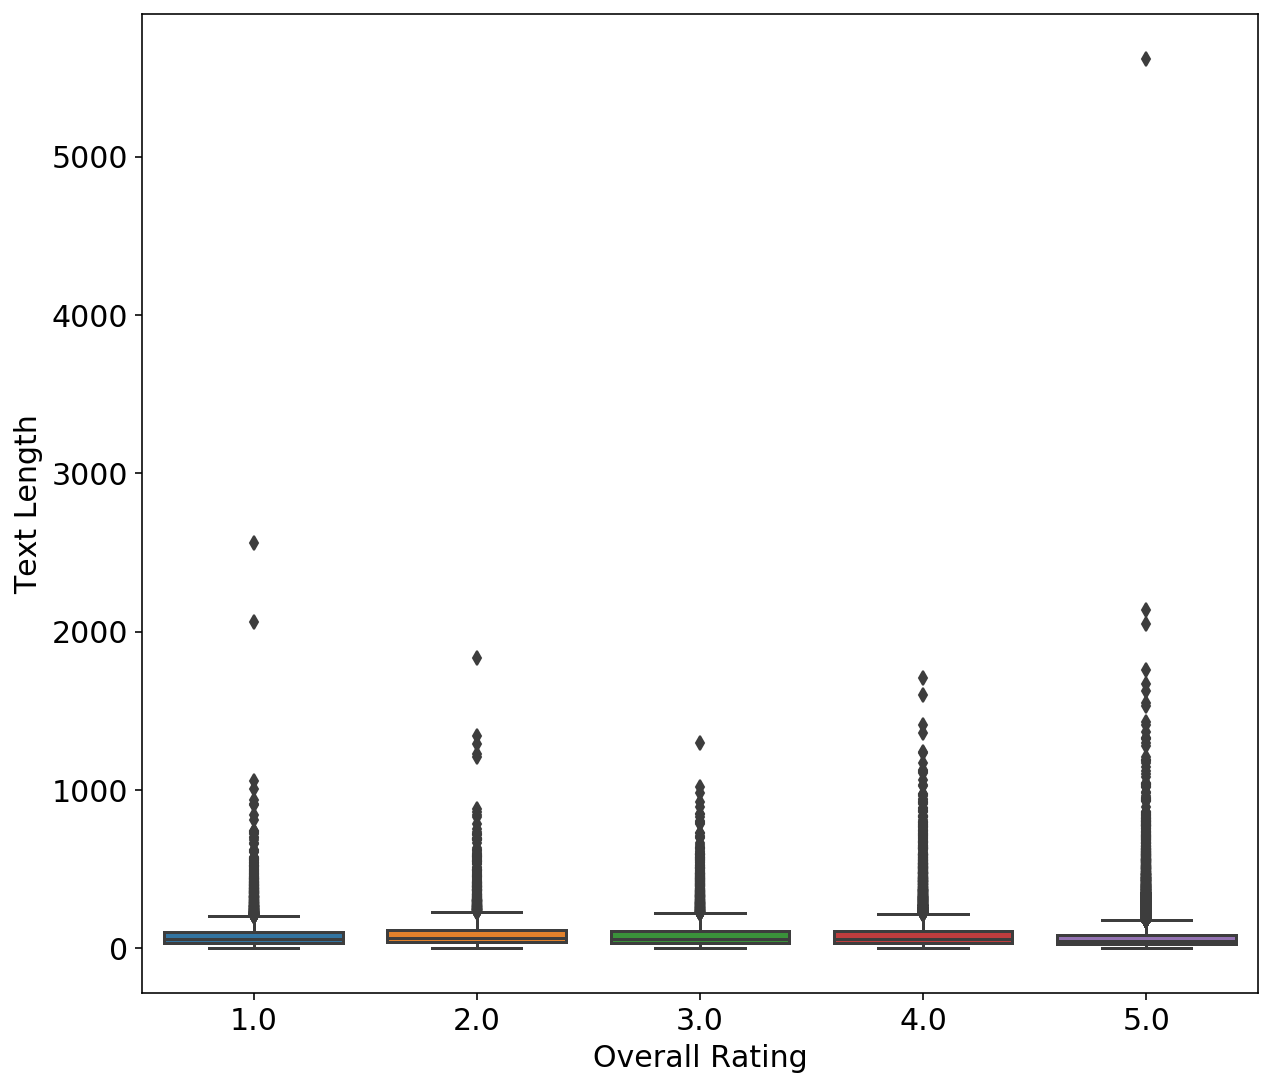

In [17]:
plt.figure(figsize=(10,9))
plt.rcParams.update({'font.size': 15})
sns.boxplot(x = 'overall', y = 'text_len', data = rev_train)
plt.ylabel('Text Length')
plt.xlabel('Overall Rating')
plt.savefig('Review Length by Star Count Distribution',dpi = 600)

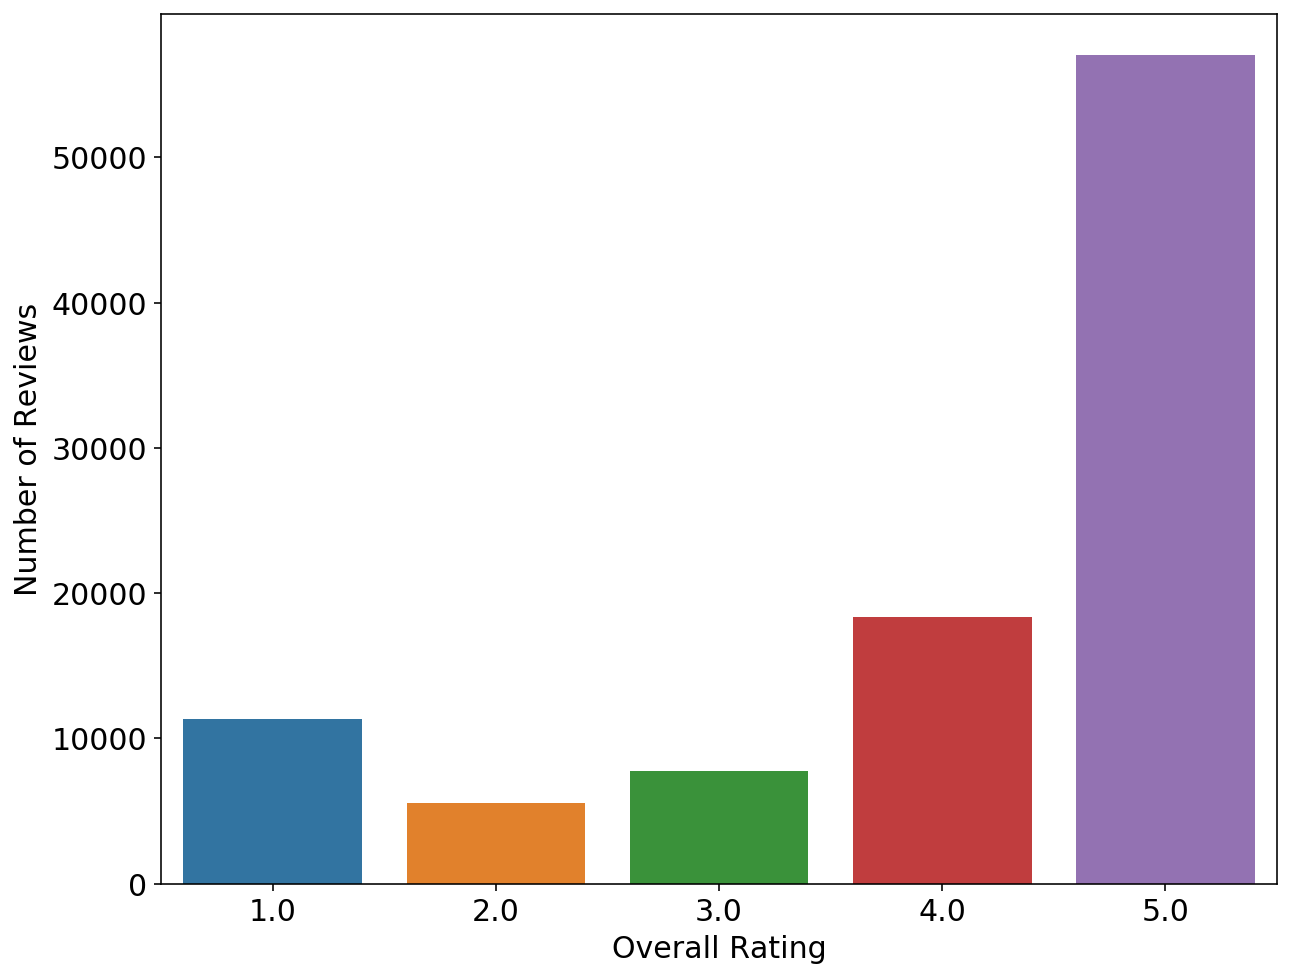

In [16]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 15})
sns.countplot('overall', data = rev_train)
plt.ylabel('Number of Reviews')
plt.xlabel('Overall Rating');
plt.savefig('Num Reviews by Star Count Distribution', dpi = 600)

In [18]:
rev_train = rev_train[rev_train.overall != 3.0]

rev_train['target'] = rev_train.overall.apply(lambda x: 1 if x > 3 else 0)

print(len(rev_train))
mask = (rev_train['reviewText'].str.len() > 50) & (rev_train['reviewText'].str.len() < 200)
rev_train = rev_train.loc[mask]
print(len(rev_train))

rev_train.head()

92200
33694


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,text_len,target
1,A20DWVV8HML3AW,0981850006,Cyndy,"[0, 0]","My husband rarely asks for anything specific, ...",5.0,Just what my husband wanted,1371081600,"06 13, 2013",33,1
2,A3RVP3YBYYOPRH,0981850006,John Warren,"[9, 11]",This guy knows his stuff. I love the seriously...,5.0,Love This Show!,1257984000,"11 12, 2009",29,1
5,A2R9T5D7UVQZB0,0981850006,S. Samaras,"[6, 8]",The DVD is very useful and very detailed and m...,5.0,Good Stuff,1253577600,"09 22, 2009",27,1
6,A2MH49GAEWEI95,0981850006,Thomas O.,"[0, 0]",Have learned to use my grill for making many t...,5.0,wonderfull ideas for using your grill for more...,1395532800,"03 23, 2014",23,1
8,A3OGMCRM3NL8OM,144072007X,Ivan Moreno,"[1, 1]",This metal detector is light and powerful. It ...,5.0,Tesoro Sand Shark metal detector,1360108800,"02 6, 2013",23,1


In [0]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['come','order','try','go','get','make','drink','plate','dish','restaurant','place',
                  'would','really','like','great','service','came','got'])

nlp = spacy.load('en', disable=['parser', 'ner'])

def strip_newline(series):
    return [review.replace('\n','') for review in series]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

# def lemmatization(texts, allowed_postags=['NOUN','ADV']):
#     texts_out = []
#     for sent in texts:
#         doc = nlp(" ".join(sent)) 
#         texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#     return texts_out

def get_corpus(df):
    """
    Get Bigram Model, Corpus, id2word mapping
    """
    
    df['reviewText'] = strip_newline(df.reviewText)
    words = list(sent_to_words(df.reviewText))
    words = remove_stopwords(words)
    bigram = bigrams(words)
    bigram = [bigram[review] for review in words]
#     lemma = lemmatization(bigram)
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

#bigram_train4[0]

In [0]:
train_corpus4, train_id2word4, bigram_train4 = get_corpus(rev_train)

In [0]:
with open('train_corpus4.pkl', 'rb') as f:
    train_corpus4 = pickle.load(f)
with open('train_id2word4.pkl', 'rb') as f:
    train_id2word4 = pickle.load(f)
with open('bigram_train4.pkl', 'rb') as f:
    bigram_train4 = pickle.load(f)

In [0]:
import logging
logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_train4 = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus4,
                           num_topics=20,
                           id2word=train_id2word4,
                           chunksize=100,
                           workers=7, # Num. Processing Cores - 1
                           passes=50,
                           eval_every = 1,
                           per_word_topics=True)
    lda_train4.save('lda_train4.model')

In [29]:
coherence_model_lda = CoherenceModel(model=lda_train4, texts=bigram_train4, dictionary=train_id2word4, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
coherence_lda

0.2970540320636918

In [30]:
lda_train4.print_topics(20,num_words=15)[:10]

[(0,
  '0.053*"love" + 0.045*"use" + 0.037*"plants" + 0.035*"garden" + 0.029*"small" + 0.029*"product" + 0.023*"take" + 0.021*"easy" + 0.021*"plant" + 0.021*"stuff" + 0.013*"works" + 0.013*"kids" + 0.012*"around" + 0.012*"tree" + 0.012*"also"'),
 (1,
  '0.035*"pool" + 0.028*"product" + 0.023*"purchase" + 0.022*"together" + 0.022*"looks" + 0.019*"bought" + 0.019*"gift" + 0.019*"husband" + 0.018*"easy_put" + 0.017*"material" + 0.016*"loves" + 0.016*"pleased" + 0.016*"loved" + 0.015*"said" + 0.013*"exactly"'),
 (2,
  '0.044*"table" + 0.031*"getting" + 0.028*"pot" + 0.021*"squirrels" + 0.019*"actually" + 0.017*"instructions" + 0.015*"green" + 0.015*"flowers" + 0.014*"fish" + 0.014*"however" + 0.014*"felco" + 0.013*"works" + 0.013*"filter" + 0.012*"chair" + 0.012*"animals"'),
 (3,
  '0.031*"handle" + 0.028*"tool" + 0.022*"good" + 0.022*"comfortable" + 0.017*"plastic" + 0.016*"use" + 0.016*"metal" + 0.013*"wood" + 0.013*"hand" + 0.012*"easy_set" + 0.012*"used" + 0.012*"quality" + 0.011*"feel

In [0]:
train_vecs = []
for i in range(len(rev_train)):
    top_topics = lda_train4.get_document_topics(train_corpus4[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(20)]
    topic_vec.extend([rev_train.iloc[i].overall]) # counts of reviews
    topic_vec.extend([len(rev_train.iloc[i].reviewText)]) # length review
    train_vecs.append(topic_vec)

In [34]:
train_vecs[4]

[0.005,
 0.005,
 0.005,
 0.19834073,
 0.12976786,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.5868914,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 5.0,
 131]

In [0]:

X = np.array(train_vecs)

y = np.array(rev_train.target)

with open('y.pkl', 'wb') as f:
    pickle.dump(y, f)

with open('X.pkl', 'wb') as f:
    pickle.dump(X, f)

In [36]:
kf = KFold(5, shuffle=True, random_state=42)
cv_lr_f1, cv_lrsgd_f1, cv_svcsgd_f1,  = [], [], []

for train_ind, val_ind in kf.split(X, y):
    # Assign CV IDX
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind]
    
    # Scale Data
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_val_scale = scaler.transform(X_val)

    # Logisitic Regression
    lr = LogisticRegression(
        class_weight= 'balanced',
        solver='newton-cg',
        fit_intercept=True
    ).fit(X_train_scale, y_train)

    y_pred = lr.predict(X_val_scale)
    cv_lr_f1.append(f1_score(y_val, y_pred, average='binary'))
    
    # Logistic Regression Mini-Batch SGD
    sgd = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        loss='log',
        class_weight='balanced'
    ).fit(X_train_scale, y_train)
    
    y_pred = sgd.predict(X_val_scale)
    cv_lrsgd_f1.append(f1_score(y_val, y_pred, average='binary'))
    
    # SGD Modified Huber
    sgd_huber = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        alpha=20,
        loss='modified_huber',
        class_weight='balanced'
    ).fit(X_train_scale, y_train)
    
    y_pred = sgd_huber.predict(X_val_scale)
    cv_svcsgd_f1.append(f1_score(y_val, y_pred, average='binary'))

print(f'Logistic Regression Val f1: {np.mean(cv_lr_f1):.3f} +- {np.std(cv_lr_f1):.3f}')
print(f'Logisitic Regression SGD Val f1: {np.mean(cv_lrsgd_f1):.3f} +- {np.std(cv_lrsgd_f1):.3f}')
print(f'SVM Huber Val f1: {np.mean(cv_svcsgd_f1):.3f} +- {np.std(cv_svcsgd_f1):.3f}')


Logistic Regression Val f1: 1.000 +- 0.000
Logisitic Regression SGD Val f1: 1.000 +- 0.000
SVM Huber Val f1: 0.985 +- 0.011
